#  Deep Neural Network Activation Function & Depth Analysis

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [2]:
# Synthetic classification dataset
X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
X = StandardScaler().fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tensor conversion
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [3]:
def train_model(model, optimizer, criterion, epochs=50):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
    return train_losses

def evaluate_model(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            pred = output.argmax(dim=1)
            correct += (pred == y_batch).sum().item()
    return correct / len(test_dataset)


# Comparing Sigmoid, Tanh, ReLU
python
Copy
Edit


In [4]:
class SimpleNN(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        self.activation = activation_fn
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

activations = {
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "ReLU": F.relu
}

results = {}
for name, act_fn in activations.items():
    model = SimpleNN(act_fn)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = train_model(model, optimizer, criterion)
    acc = evaluate_model(model)
    results[name] = {"loss": losses, "accuracy": acc}
    print(f"{name} Accuracy: {acc:.2f}")


Sigmoid Accuracy: 0.97
Tanh Accuracy: 0.97
ReLU Accuracy: 0.96


# ReLU Variants: ReLU vs LeakyReLU vs PReLU

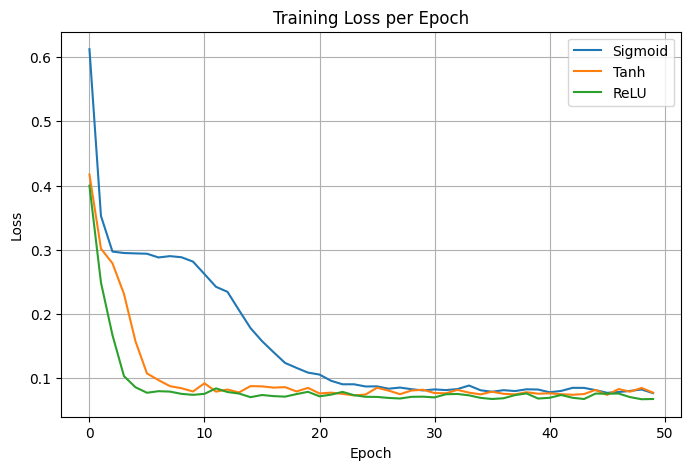

In [5]:
plt.figure(figsize=(8, 5))
for name in results:
    plt.plot(results[name]["loss"], label=f"{name}")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
class ReLUVariantsNN(nn.Module):
    def __init__(self, activation_layer):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 2)
        self.activation = activation_layer
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

variants = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(0.01),
    "PReLU": nn.PReLU()
}

variant_results = {}
for name, act_layer in variants.items():
    model = ReLUVariantsNN(act_layer)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = train_model(model, optimizer, criterion)
    acc = evaluate_model(model)
    variant_results[name] = {"loss": losses, "accuracy": acc}
    print(f"{name} Accuracy: {acc:.2f}")


ReLU Accuracy: 0.96
LeakyReLU Accuracy: 0.97
PReLU Accuracy: 0.97


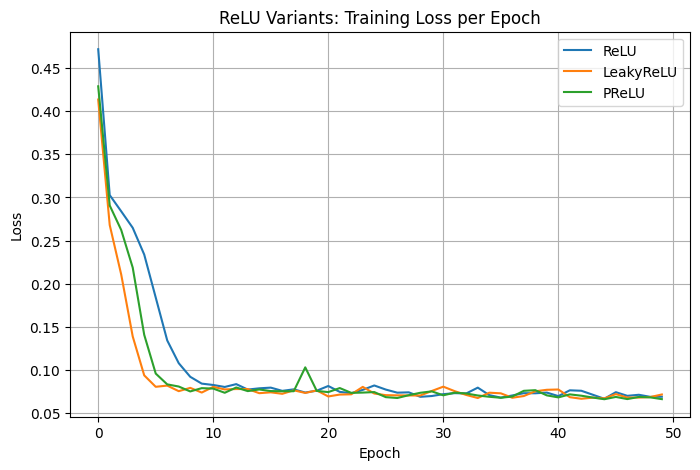

In [7]:
plt.figure(figsize=(8, 5))
for name in variant_results:
    plt.plot(variant_results[name]["loss"], label=f"{name}")
plt.title("ReLU Variants: Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# Role of Depth in ANN

In [8]:
def make_deep_model(depth, act_fn=F.relu):
    layers = []
    layers.append(nn.Linear(2, 16))
    for _ in range(depth - 1):
        layers.append(nn.Linear(16, 16))
    layers.append(nn.Linear(16, 2))

    class DeepNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.layers = nn.ModuleList(layers)
            self.activation = act_fn

        def forward(self, x):
            for layer in self.layers[:-1]:
                x = self.activation(layer(x))
            return self.layers[-1](x)

    return DeepNN()

depths = [1, 2, 3, 5, 10]
depth_results = {}

for d in depths:
    model = make_deep_model(d)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = train_model(model, optimizer, criterion)
    acc = evaluate_model(model)
    depth_results[d] = {"loss": losses[-1], "accuracy": acc}
    print(f"Depth {d} - Accuracy: {acc:.2f}, Final Loss: {losses[-1]:.4f}")


Depth 1 - Accuracy: 0.97, Final Loss: 0.0735
Depth 2 - Accuracy: 0.97, Final Loss: 0.0708
Depth 3 - Accuracy: 0.96, Final Loss: 0.0715
Depth 5 - Accuracy: 0.96, Final Loss: 0.0676
Depth 10 - Accuracy: 0.96, Final Loss: 0.0715


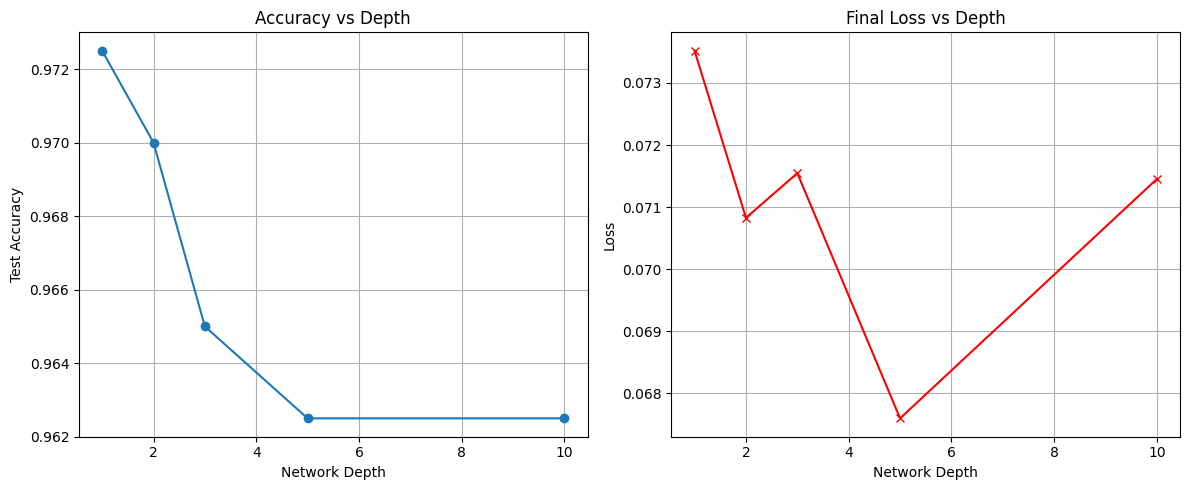

In [9]:
accs = [depth_results[d]["accuracy"] for d in depths]
losses = [depth_results[d]["loss"] for d in depths]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(depths, accs, marker='o')
plt.title("Accuracy vs Depth")
plt.xlabel("Network Depth")
plt.ylabel("Test Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(depths, losses, marker='x', color='red')
plt.title("Final Loss vs Depth")
plt.xlabel("Network Depth")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


ReLU effectively mitigates the vanishing gradient problem seen with Sigmoid and Tanh.
- Among ReLU variants, PReLU showed slightly better performance, especially on noisy data.
- Increasing depth improves model expressiveness to a point, but too much depth can cause overfitting or training instability.
